# Global constants

In [21]:
GRAIN_TYPE = 'WheatAdded_Type'
#GRAIN_TYPE = 'newWheatData'
#GRAIN_TYPE = 'CornAdded_Type'
#GRAIN_TYPE = 'cleaned_data'
# GRAIN_TYPE = 'Oats'

# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
# GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_bayes_two_targ_kcv_dnn_mc.h5'

In [22]:
#Import libraries
import requests
import pandas as pd
import kerastuner as kt

#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.10.0


In [23]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[]


## Helper functions

In [24]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

In [25]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)




From USDA:  ../Datasets/processed/WheatAdded_Type.csv


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [26]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                   # 'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type',
                    ]]

df_targets = df[['Density','M%']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [27]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize the entire dataset (input features)
dataset_x_norm = scaler_input.fit_transform(dataset_x)  # Use transform, NOT fit_transform

# Normalize the entire dataset (output targets)
dataset_y_norm = scaler_output.fit_transform(dataset_y)  # Use transform, NOT fit_transform


## Normalize datasets

In [28]:
# Perform train-test split on RAW DATA
X_train, X_test, y_train, y_test = train_test_split(dataset_x_norm, dataset_y_norm, 
                                                    test_size=0.2
                                                    ,random_state=42
                                                    )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Defining and Running model with KCV

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import space_eval

# Assuming your dataset_x_norm and dataset_y_norm are already defined and preprocessed

# Define the space of hyperparameters to search
space = {
    'num_layers': hp.choice('num_layers', [3, 4,5,6,7]),
    'units_per_layer': hp.choice('units_per_layer', [ 128,140, 180,256,300,336,360,400]),
    'activation': hp.choice('activation', ['relu', 'tanh', 'sigmoid']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'epochs': hp.choice('epochs', [185,190,195,200,205,210,215,220,225,230])
}

def objective(params):
    model = Sequential()
    model.add(Dense(params['units_per_layer'], input_dim=6, activation=params['activation']))
    for _ in range(params['num_layers']):
        model.add(Dense(params['units_per_layer'], activation='relu'))
    model.add(Dense(2,activation=params['activation']))  # Output layer
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mean_squared_error')
    
    # Using a fixed validation split for simplicity
    model.fit(X_train, y_train, epochs=params['epochs'], verbose=0, validation_split=0.15)
    
    # Evaluate the model
    mse = model.evaluate(X_val, y_val, verbose=0)
    return {'loss': mse, 'status': STATUS_OK}

trials = Trials()
best = fmin(objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10700,  # Adjusted number of evaluations
            trials=trials)

# A more efficient way to retrieve the best parameters
best_params = space_eval(space, best)
print(f"Best hyperparameters: {best_params}")

# Retrain the model with the best hyperparameters
model = Sequential()
model.add(Dense(best_params['units_per_layer'], input_dim=6, activation=best_params['activation']))
for _ in range(best_params['num_layers'] - 1):  # Adjust for initial layer
    model.add(Dense(best_params['units_per_layer'], activation=best_params['activation']))
model.add(Dense(2))
model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

# Using all data for training this time
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), epochs=best_params['epochs'], verbose=0)

# Save the model
model.save('best_model.h5')

print("Model saved as best_model.h5")

  0%|          | 0/10700 [00:00<?, ?trial/s, best loss=?]

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

In [ ]:
# Loss across k folds
print(best_params)

{'activation': 'tanh', 'epochs': 190, 'learning_rate': 0.0017349034647500424, 'num_layers': 4, 'units_per_layer': 336}


### Loss curves

In [ ]:
def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()



# # Loss across k folds
# plot_line(arr_loss, "Loss across k-folds", "Value of k")

# # Training and Validation Loss
# plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

26/26 [==============================] - 0s 420us/step


Elapsed time: 0.0244 seconds
Maxval here is:  0.9308662
Maxval here is:  24.41


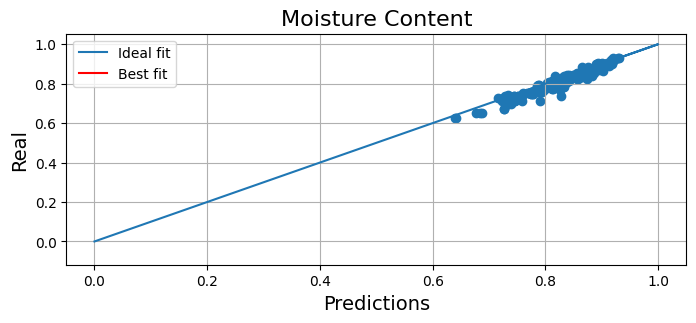

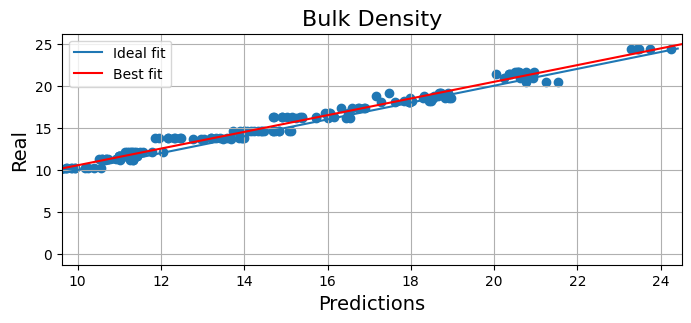

In [ ]:
import time

start_time = time.time()
Y_pred_normalized = model.predict(X_test)
end_time = time.time()
Y_pred_normalized_entire = model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = scaler_output.inverse_transform(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Bulk Density
scatter_plot(trueValues=Y_actual[:,1], 
             predictions=Y_pred[:,1], 
             title="Bulk Density")
plt.xlim([min(min(Y_pred[:,1]), min(Y_actual[:,1]))-0.1, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1])
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_BD.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [ ]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
# mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("{:#.4g}".format(mc_r2_score))




0.9386


### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sigfig import round

#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_MC: ', "{0:.4g}".format(rmse_mc))

RMSE_MC:  0.02464


Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round
print("DENSITY")
mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

print("MOISTURE")
mc_r2_score = r2_score(y_true=Y_actual[:, 1], y_pred=Y_pred[:, 1])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 1], Y_pred[:, 1], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 1], Y_pred[:, 1])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,1])):
    sum = Y_actual[:,1][i] - Y_pred[:,1][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))


R^2: 0.8720
Mean Squared Error:  0.0006073
Mean Absolute Error:  0.01935
Min Absolute Error:  6.467866897585939e-05
Max Absolute Error:  0.08851592350006088
R^2: 0.9613
Mean Squared Error:  0.544
Mean Absolute Error:  0.6017
Min Absolute Error:  0.0027669143676760655
Max Absolute Error:  1.885869026184082


/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.8791
Mean Squared Error:  0.0005484
Mean Absolute Error:  0.01872
Min Absolute Error:  1.3285255432093912e-05
Max Absolute Error:  0.08851592350006099


/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
